In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from curvemetrics.datafetcher import DataFetcher
from curvemetrics.src.metricsprocessor import MetricsProcessor
import timeit
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
from web3 import Web3
import matplotlib.pyplot as plt
from curvemetrics.datahandler import DataHandler
import json
from curvemetrics.src.queries import queries
import ccxt
from datetime import datetime, timedelta
from dotenv import load_dotenv
from dateutil.parser import parse
import os
from curvemetrics.stars import *
import curvesim
from scipy.stats import pearsonr
from roufcp import roufCP
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [3]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)

pool = '0xceaf7747579696a2f0bb206a14210e3c9e6fb269' # UST pool

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2022-02-28"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2022-06-01"))

In [4]:
swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)

In [5]:
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)
pool_metrics = metricsprocessor.process_metrics_for_pool(pool, pool_data, swaps_data, lp_data)

In [6]:
pool_data['approxTimestamp'] = pool_data['block'].apply(lambda x: datahandler.get_block_timestamp(x)[0]['timestamp'])
pool_data.index = pool_data['approxTimestamp'].apply(datetime.fromtimestamp)
pool_data.head()

,id,pool_id,block,totalValueLockedUSD,inputTokenBalances,inputTokenWeights,approxTimestamp,outputTokenSupply
approxTimestamp,,,,,,,,
2022-02-27 23:46:23,2914437,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14291294,1.189813e+09,"[729602966560417887437631762, 420675648975802]","[100.0, 0.0]",1646005583,1.161918e+27
2022-02-27 23:46:28,2914380,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14291295,1.189813e+09,"[729602966560417887437631762, 420675648975802]","[100.0, 0.0]",1646005588,1.161918e+27
2022-02-27 23:46:45,2914276,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14291296,1.189813e+09,"[729602966560417887437631762, 420675648975802]","[100.0, 0.0]",1646005605,1.161918e+27
2022-02-27 23:46:51,2914404,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14291297,1.189813e+09,"[729602966560417887437631762, 420675648975802]","[100.0, 0.0]",1646005611,1.161918e+27
2022-02-27 23:47:20,2914408,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14291298,1.189813e+09,"[729602966560417887437631762, 420675648975802]","[100.0, 0.0]",1646005640,1.161918e+27


<Axes: xlabel='approxTimestamp'>

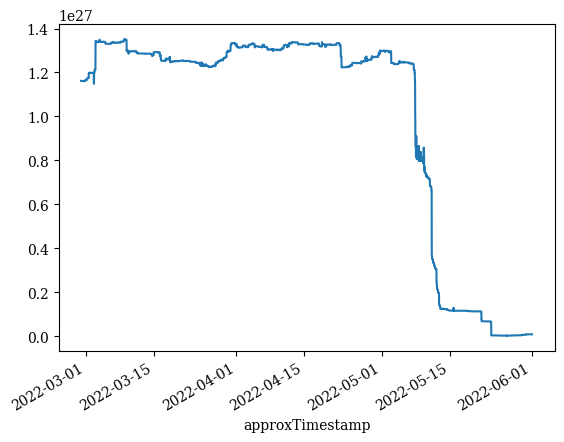

In [7]:
pool_data['outputTokenSupply'].plot()

In [8]:
async def get_snapshots():
    datafetcher = DataFetcher(token_metadata=token_metadata)
    try:
        snapshots = datafetcher.get_snapshots(start_ts, end_ts, pool)
    except Exception as e:
        print(f'excepted: {e}')
        return 
    finally:
        await datafetcher.close()
    return snapshots
    
snapshots = await get_snapshots()

In [9]:
df = pd.DataFrame.from_dict([x for y in snapshots for x in y])
for col in ['A', 'offPegFeeMultiplier', 'timestamp', 'virtualPrice', 'lastPricesTimestamp', 'block_gte', 'block_lt']:
    df[col] = df[col].astype(int)
for col in ['adminFee', 'fee', 'lpPriceUSD', 'tvl', 'totalDailyFeesUSD', 'lpFeesUSD']:
    df[col] = df[col].astype(float)
for col in ['normalizedReserves', 'reserves']:
    df[col] = df[col].apply(lambda x: [int(y) for y in x])
for col in ['reservesUSD']:
    df[col] = df[col].apply(lambda x: [float(y) for y in x])
df = df.sort_values(by='timestamp')
df.index = df['timestamp'].apply(datetime.fromtimestamp)
df.head()

,A,adminFee,fee,id,normalizedReserves,offPegFeeMultiplier,reserves,timestamp,virtualPrice,lpPriceUSD,tvl,totalDailyFeesUSD,reservesUSD,lpFeesUSD,lastPricesTimestamp,lastPrices,pool_id,block_gte,block_lt
timestamp,,,,,,,,,,,,,,,,,,,
2022-02-28,162,0.0,0.0004,0xceaf7747579696a2f0bb206a14210e3c9e6fb269-164...,"[420675648975802000000000000, 7296029665604178...",0,"[420675648975802, 729602966560417887437631762]",1646006400,1002538059871076792,0.996574,1.157937e+09,65623.210077,"[413447903.00957865, 744489567.7127233]",32811.605038,0,0,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1646006400,1646092800
2022-03-01,176,0.0,0.0004,0xceaf7747579696a2f0bb206a14210e3c9e6fb269-164...,"[455978010849159000000000000, 6981334317367314...",0,"[455978010849159, 698133431736731494665545838]",1646092800,1002565962509041514,0.995985,1.160526e+09,64455.428327,"[448143725.131349, 712382226.5397497]",32227.714163,0,0,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1646092800,1646179200
2022-03-02,191,0.0,0.0004,0xceaf7747579696a2f0bb206a14210e3c9e6fb269-164...,"[419542572000524000000000000, 7669830630092840...",0,"[419542572000524, 766983063009284056160287245]",1646179200,1002600111706633152,0.996849,1.194977e+09,79059.197132,"[412334293.7466758, 782642927.037303]",39529.598566,0,0,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1646179200,1646265600
2022-03-03,200,0.0,0.0004,0xceaf7747579696a2f0bb206a14210e3c9e6fb269-164...,"[490837785615827000000000000, 8377077928926498...",0,"[490837785615827, 837707792892649842114846509]",1646265600,1002634329761565463,0.996558,1.337237e+09,81567.507736,"[482419607.0958179, 854817454.8894364]",40783.753868,0,0,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1646265600,1646352000
2022-03-04,200,0.0,0.0004,0xceaf7747579696a2f0bb206a14210e3c9e6fb269-164...,"[464495985974186000000000000, 8606823499199769...",0,"[464495985974186, 860682349919976995363905593]",1646352000,1002643259787253163,0.996955,1.334795e+09,23820.371913,"[456529585.9814625, 878265035.1747837]",11910.185957,0,0,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1646352000,1646438400


<Axes: xlabel='timestamp'>

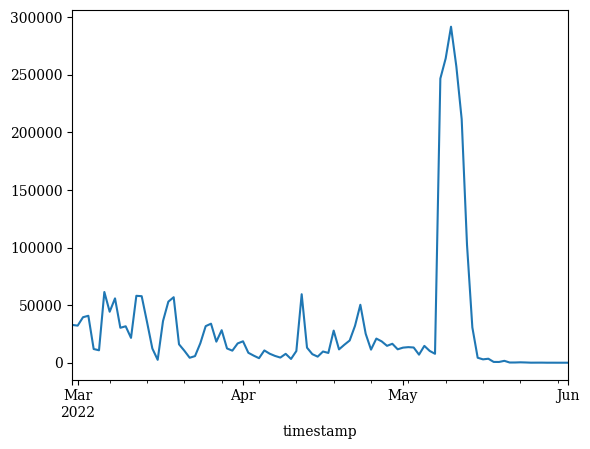

In [10]:
df['lpFeesUSD'].plot()

In [11]:
pool_df = pool_data[['totalValueLockedUSD', 'inputTokenBalances', 'outputTokenSupply']]
pool_df.head()

,totalValueLockedUSD,inputTokenBalances,outputTokenSupply
approxTimestamp,,,
2022-02-27 23:46:23,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27
2022-02-27 23:46:28,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27
2022-02-27 23:46:45,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27
2022-02-27 23:46:51,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27
2022-02-27 23:47:20,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27


# Use CurveSim to Calc Prices using LP and Swap Events

Ensure we get the same virtual price as the daily virtual prices from Convex finance daily snapshots.

Check this against Messari minutely data.

This allows us to price tokens on a minutely basis, both in terms of each other (swaps) and in terms of the LP token (deposit/withdraw).

Match the LP token balances and token reserves in the pool with the minutely historical data.

Note: It seems that the 'D' (and therefore virtual_price) values disagree between subgraph and what would be calculated by the curvesim MetaPool. This seems to be due to the conversion from the self.rates(), the value in the subgraph doesn't seem to do the conversion?

In [12]:
curvesimpool = curvesim.pool.get(pool)

{'dict': {'name': 'Curve.fi Factory USD Metapool: wormhole v2 UST-3Pool', 'address': '0xCEAF7747579696A2F0bb206a14210e3c9e6fB269', 'chain': 'mainnet', 'symbol': 'UST_whv23CRV-f', 'version': 1, 'pool_type': 'STABLE_FACTORY', 'params': {'A': 176, 'fee': 4000000, 'fee_mul': None}, 'coins': {'names': ['UST', '3Crv'], 'addresses': ['0xa693B19d2931d498c5B318dF961919BB4aee87a5', '0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490']}, 'reserves': {'D': 1154111140909172016077344359, 'by_coin': [455978010849159000000000000, 698133431736731494665545838], 'virtual_price': 1002565962509041514, 'tokens': 1151157314398416763628167430}, 'basepool': {'name': 'Curve.fi DAI/USDC/USDT', 'address': '0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7', 'chain': 'mainnet', 'symbol': '3Crv', 'version': 1, 'pool_type': 'REGISTRY_V1', 'params': {'A': 4333, 'fee': 2999999, 'fee_mul': None}, 'coins': {'names': ['DAI', 'USDC', 'USDT'], 'addresses': ['0x6B175474E89094C44Da98b954EedeAC495271d0F', '0xA0b86991c6218b36c1d19D4a2e9Eb0cE

In [13]:
curvesimpool.rates()

[1000000000000000000, 1020397123198961633]

In [14]:
print(f'Time: {datetime.fromtimestamp(curvesimpool.metadata["timestamp"])}')
print(f'Timestamp: {curvesimpool.metadata["timestamp"]}')
print(f'Balances: {curvesimpool.x}')
print(f'Precision: {curvesimpool.p}')
print(f'A: {curvesimpool.A}')
print(f'Tokens: {curvesimpool.tokens}')
print(f'D: {curvesimpool.D()}')
print(f'xp: {curvesimpool._xp()}')
print(f'Virtual price: {curvesimpool.get_virtual_price()}')

Time: 2022-03-01 00:00:00
Timestamp: 1646092800
Balances: [455978010849159000000000000, 698133431736731494665545838]
Precision: [1000000000000000000, 1000000000000000000]
A: 176
Tokens: 1151157314398416763628167430
D: 1168184442009001823559191158
xp: [455978010849159000000000000, 712373345353179478210446944]
Virtual price: 1014791312531843891


In [15]:
reserves = df.iloc[1]['normalizedReserves']
timestamp = df.iloc[1]['timestamp']
print(f'Reserves were: {reserves}, at {datetime.fromtimestamp(timestamp)}')
df.head(2)

Reserves were: [455978010849159000000000000, 698133431736731494665545838], at 2022-03-01 00:00:00


,A,adminFee,fee,id,normalizedReserves,offPegFeeMultiplier,reserves,timestamp,virtualPrice,lpPriceUSD,tvl,totalDailyFeesUSD,reservesUSD,lpFeesUSD,lastPricesTimestamp,lastPrices,pool_id,block_gte,block_lt
timestamp,,,,,,,,,,,,,,,,,,,
2022-02-28,162,0.0,0.0004,0xceaf7747579696a2f0bb206a14210e3c9e6fb269-164...,"[420675648975802000000000000, 7296029665604178...",0,"[420675648975802, 729602966560417887437631762]",1646006400,1002538059871076792,0.996574,1.157937e+09,65623.210077,"[413447903.00957865, 744489567.7127233]",32811.605038,0,0,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1646006400,1646092800
2022-03-01,176,0.0,0.0004,0xceaf7747579696a2f0bb206a14210e3c9e6fb269-164...,"[455978010849159000000000000, 6981334317367314...",0,"[455978010849159, 698133431736731494665545838]",1646092800,1002565962509041514,0.995985,1.160526e+09,64455.428327,"[448143725.131349, 712382226.5397497]",32227.714163,0,0,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1646092800,1646179200


In [16]:
lp_data.index = lp_data['timestamp'].apply(datetime.fromtimestamp)
lp_data.head()

,id,block,liquidityProvider,removal,timestamp,tokenAmounts,totalSupply,tx,pool_id,block_gte,block_lt
timestamp,,,,,,,,,,,
2022-02-28 06:18:58,0x263d2e1515bf675ffb09d7a4c7a8134df2fa1edfe1da...,14292955,0x0d2ebb8a2981c067866914bcd0f9c29170af138e,0,1646029138,"[0, 9959569293405077532138]",1.161928e+27,0x263d2e1515bf675ffb09d7a4c7a8134df2fa1edfe1da...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14292952,14292962
2022-02-28 06:42:02,0xb07caf5ab87878abd18bef9725688773b182fb7d1407...,14293057,0xa79828df1850e8a3a3064576f380d90aecdd3359,1,1646030522,"[406046186342, 582883167124591110552755]",1.160906e+27,0xb07caf5ab87878abd18bef9725688773b182fb7d1407...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14293052,14293062
2022-02-28 14:57:10,0xe5104f58b7285fd41340167924bbfefb1a362807f804...,14295309,0xa79828df1850e8a3a3064576f380d90aecdd3359,1,1646060230,"[0, 26547997305938964605117]",1.160579e+27,0xe5104f58b7285fd41340167924bbfefb1a362807f804...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14295302,14295312
2022-02-28 19:26:47,0x6ded917bf08c55a58ec755b133fa1603033d315c3883...,14296526,0xa79828df1850e8a3a3064576f380d90aecdd3359,0,1646076407,"[0, 5172526131806561500438342]",1.165837e+27,0x6ded917bf08c55a58ec755b133fa1603033d315c3883...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14296522,14296532
2022-03-01 03:08:07,0x62bb2ad0c62b55827f41b4882232a9f30eb8830dd453...,14298595,0xa79828df1850e8a3a3064576f380d90aecdd3359,0,1646104087,"[0, 979808005760425942085278]",1.166200e+27,0x62bb2ad0c62b55827f41b4882232a9f30eb8830dd453...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14298595,14298605


In [17]:
def calc_virtual_price(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    return (crv_balance + ust_balance * 1e12)/(row['outputTokenSupply'])
def calc_sum_reserves(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    return (crv_balance + ust_balance * 1e12)

pool_df['virtualPrice'] = pool_df.apply(calc_virtual_price, axis=1)
pool_df['sumReserves'] = pool_df.apply(calc_sum_reserves, axis=1)
pool_df

/tmp/ipykernel_371292/1787308367.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pool_df['virtualPrice'] = pool_df.apply(calc_virtual_price, axis=1)
/tmp/ipykernel_371292/1787308367.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pool_df['sumReserves'] = pool_df.apply(calc_sum_reserves, axis=1)


,totalValueLockedUSD,inputTokenBalances,outputTokenSupply,virtualPrice,sumReserves
approxTimestamp,,,,,
2022-02-27 23:46:23,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27
2022-02-27 23:46:28,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27
2022-02-27 23:46:45,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27
2022-02-27 23:46:51,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27
2022-02-27 23:47:20,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27
...,...,...,...,...,...
2022-05-31 23:58:34,8.912340e+06,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.174230,1.014900e+25
2022-05-31 23:59:11,8.912340e+06,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.174230,1.014900e+25
2022-05-31 23:59:16,8.912340e+06,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.174230,1.014900e+25


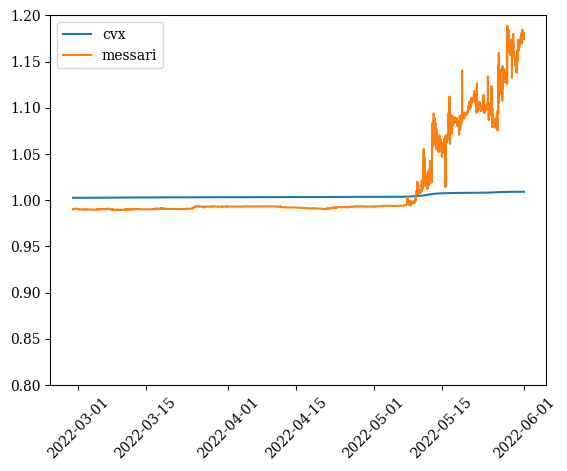

In [18]:
f, ax = plt.subplots()
ax.plot(df.index, df['virtualPrice']/1e18, label='cvx')
ax.plot(pool_df.index, pool_df['virtualPrice'], label='messari')
ax.set_ylim(0.8, 1.2)
ax.legend()
ax.tick_params(axis='x', rotation=45)

In [19]:
ust = '0xa693b19d2931d498c5b318df961919bb4aee87a5'
ust_ohlcv = datahandler.get_ohlcv_data(ust, start=start_ts, end=end_ts)
ust_ohlcv = ust_ohlcv['close']
ust_ohlcv.name = token_metadata[ust]['symbol']
ust_ohlcv.head()

timestamp
2022-02-28 00:01:00    1.004
2022-02-28 00:02:00    1.004
2022-02-28 00:03:00    1.004
2022-02-28 00:04:00    1.004
2022-02-28 00:05:00    1.004
Freq: T, Name: UST, dtype: float64

In [20]:
final_df = pool_df.resample('1min').last()
final_df = pd.merge(final_df, ust_ohlcv, how='left', left_index=True, right_index=True).fillna(method='ffill').fillna(method='bfill')
final_df['3Crv'] = 1
final_df.head()

,totalValueLockedUSD,inputTokenBalances,outputTokenSupply,virtualPrice,sumReserves,UST,3Crv
approxTimestamp,,,,,,,
2022-02-27 23:46:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.004,1
2022-02-27 23:47:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.004,1
2022-02-27 23:48:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.004,1
2022-02-27 23:49:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.004,1
2022-02-27 23:50:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.004,1


In [21]:
def calc_real_price(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    crv_value = crv_balance * row['3Crv']
    ust_value = ust_balance * row['UST']
    return (crv_value + ust_value * 1e12)/(row['outputTokenSupply'])
def calc_real_value(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    crv_value = crv_balance * row['3Crv']
    ust_value = ust_balance * row['UST']
    return (crv_value + ust_value * 1e12)

final_df['realPrice'] = final_df.apply(calc_real_price, axis=1)
final_df['realValue'] = final_df.apply(calc_real_value, axis=1)
final_df

,totalValueLockedUSD,inputTokenBalances,outputTokenSupply,virtualPrice,sumReserves,UST,3Crv,realPrice,realValue
approxTimestamp,,,,,,,,,
2022-02-27 23:46:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.00400,1,0.991431,1.151961e+27
2022-02-27 23:47:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.00400,1,0.991431,1.151961e+27
2022-02-27 23:48:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.00400,1,0.991431,1.151961e+27
2022-02-27 23:49:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.00400,1,0.991431,1.151961e+27
2022-02-27 23:50:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.161918e+27,0.989983,1.150279e+27,1.00400,1,0.991431,1.151961e+27
...,...,...,...,...,...,...,...,...,...
2022-05-31 23:56:00,8.912340e+06,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.174230,1.014900e+25,0.03289,1,0.041717,3.605615e+23
2022-05-31 23:57:00,8.912340e+06,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.174230,1.014900e+25,0.03289,1,0.041717,3.605615e+23
2022-05-31 23:58:00,8.912340e+06,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.174230,1.014900e+25,0.03289,1,0.041717,3.605615e+23


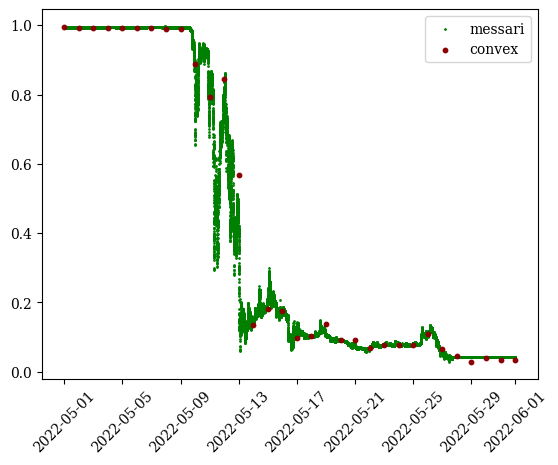

In [22]:
messari = final_df['realPrice'].loc['2022-05-01':]
convex = df['lpPriceUSD'].loc['2022-05-01':]

f, ax = plt.subplots()

ax.scatter(messari.index, messari, label='messari', c='green', s=1)
ax.scatter(convex.index, convex, label='convex', c='darkred', s=10, zorder=10)
ax.legend()
ax.tick_params(axis='x', rotation=45)
f.show()

In [23]:
# periods = 24
# cumulative_returns = final_df['realPrice'].loc['2022-04-01':].resample('1h').last().pct_change().iloc[:1000]
# detector = roufCP(delta=10, w=10)
# res = detector.fit(cumulative_returns, moving_window=periods, k=1)

# f, ax = plt.subplots()
# ax2 = ax.twinx()
# ax.plot(cumulative_returns.index, cumulative_returns, label='rolling sharpe', linewidth=1, c='black')
# ax.legend()
# ax.set_title('LP Portfolio Daily Rolling Sharpe Ratio')
# ax.set_ylabel('Sharpe Ratio')
# ax.tick_params(axis='x', rotation=45)

# ax.grid(False)
# ax2.grid(False)

# for cp in res['cp']:
#     ax.axvline(cumulative_returns.index[cp], c='red', ls='dotted')

# ax2.plot(cumulative_returns.index, res['exponential_entropy'], c='darkred')

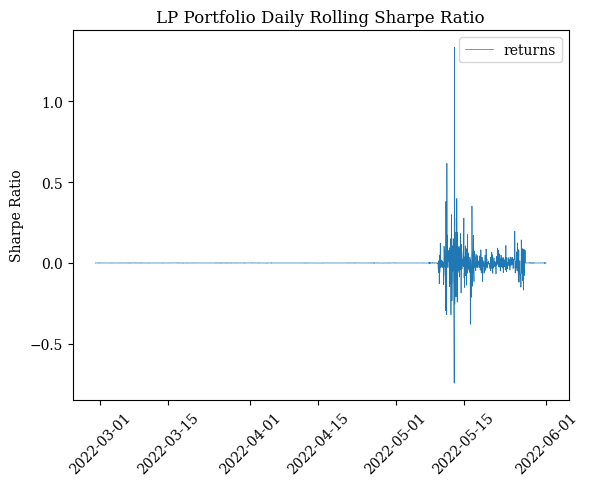

In [24]:
f, ax = plt.subplots()
periods = 60*24
cumulative_returns = final_df['realPrice'].resample('1h').last().pct_change()
ax.plot(cumulative_returns.index, cumulative_returns, label='returns', linewidth=0.5)
ax.legend()
ax.set_title('LP Portfolio Daily Rolling Sharpe Ratio')
ax.set_ylabel('Sharpe Ratio')
ax.tick_params(axis='x', rotation=45)

In [25]:
from functools import partial
from bayesian_changepoint_detection.hazard_functions import constant_hazard
from bayesian_changepoint_detection.bayesian_models import online_changepoint_detection
import bayesian_changepoint_detection.online_likelihoods as online_ll

data = cumulative_returns

hazard_function = partial(constant_hazard, 250)

R, maxes = online_changepoint_detection(
    data, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

Use scipy logsumexp().


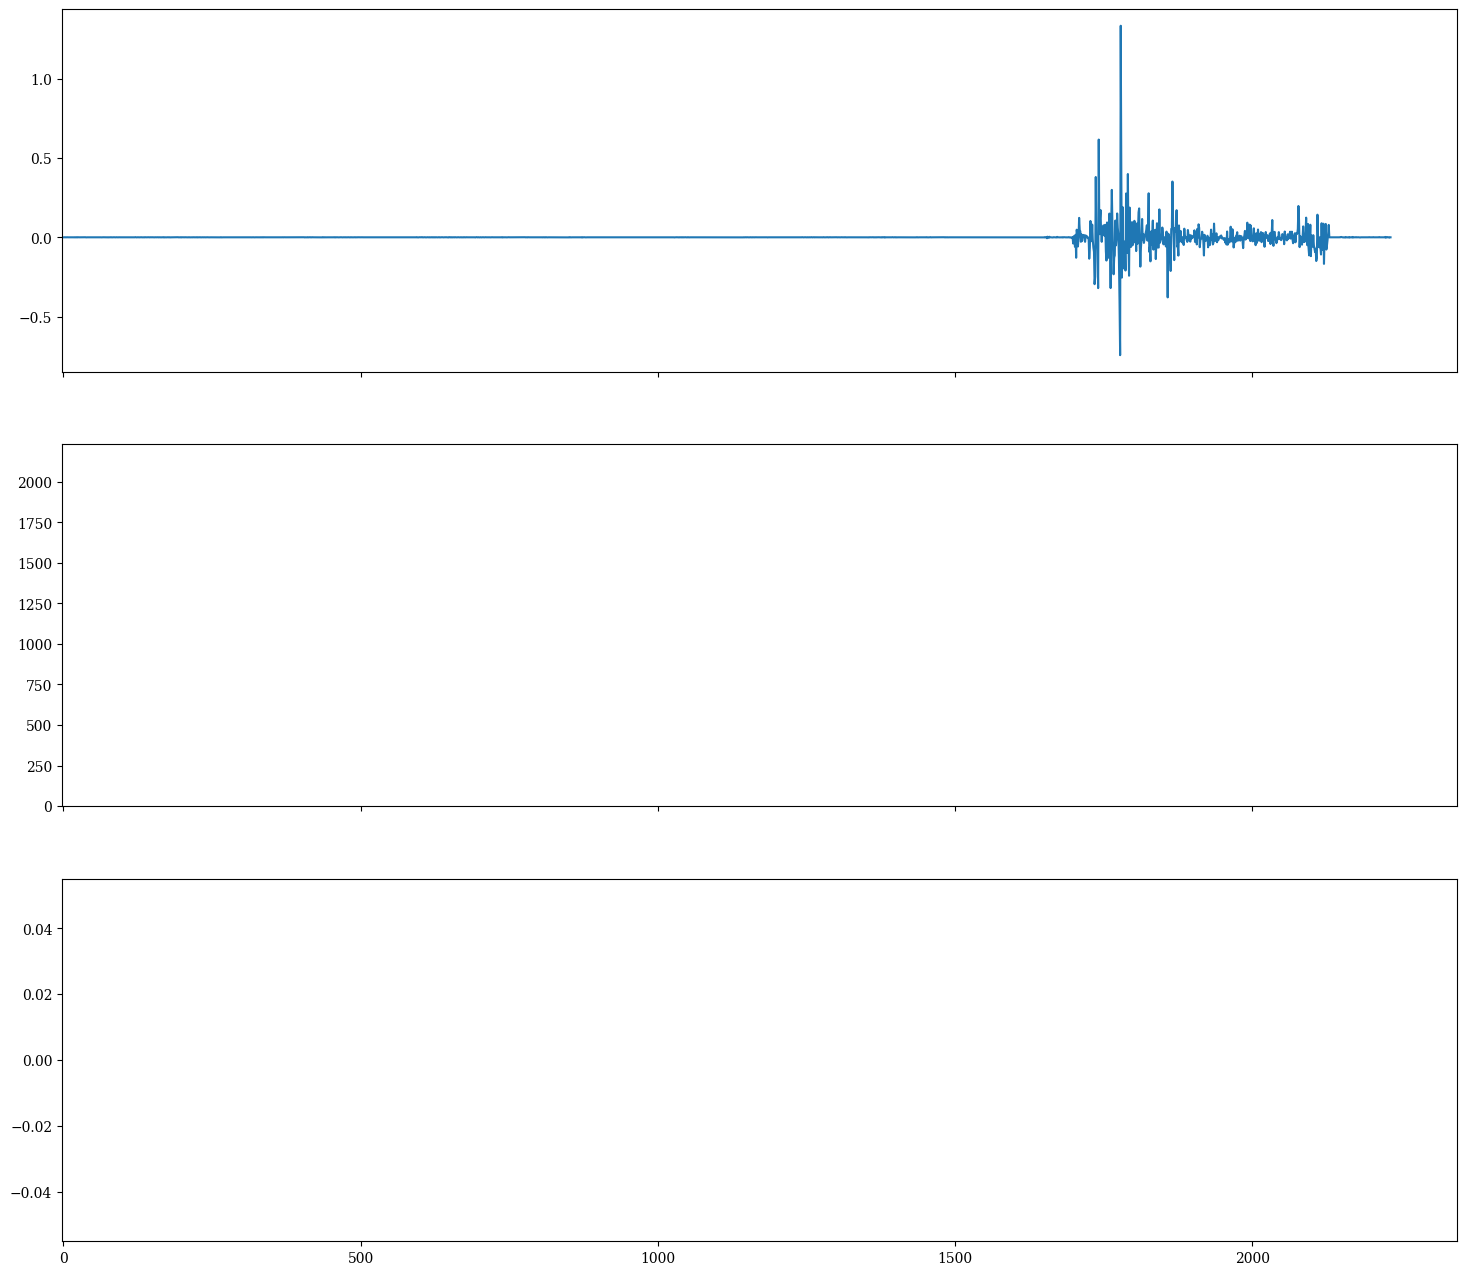

In [ ]:
import matplotlib.cm as cm
epsilon = 1e-7
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=True)
ax[0].plot(data.reset_index(drop=True))
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=10
ax[2].plot(R[Nw,Nw:-1])

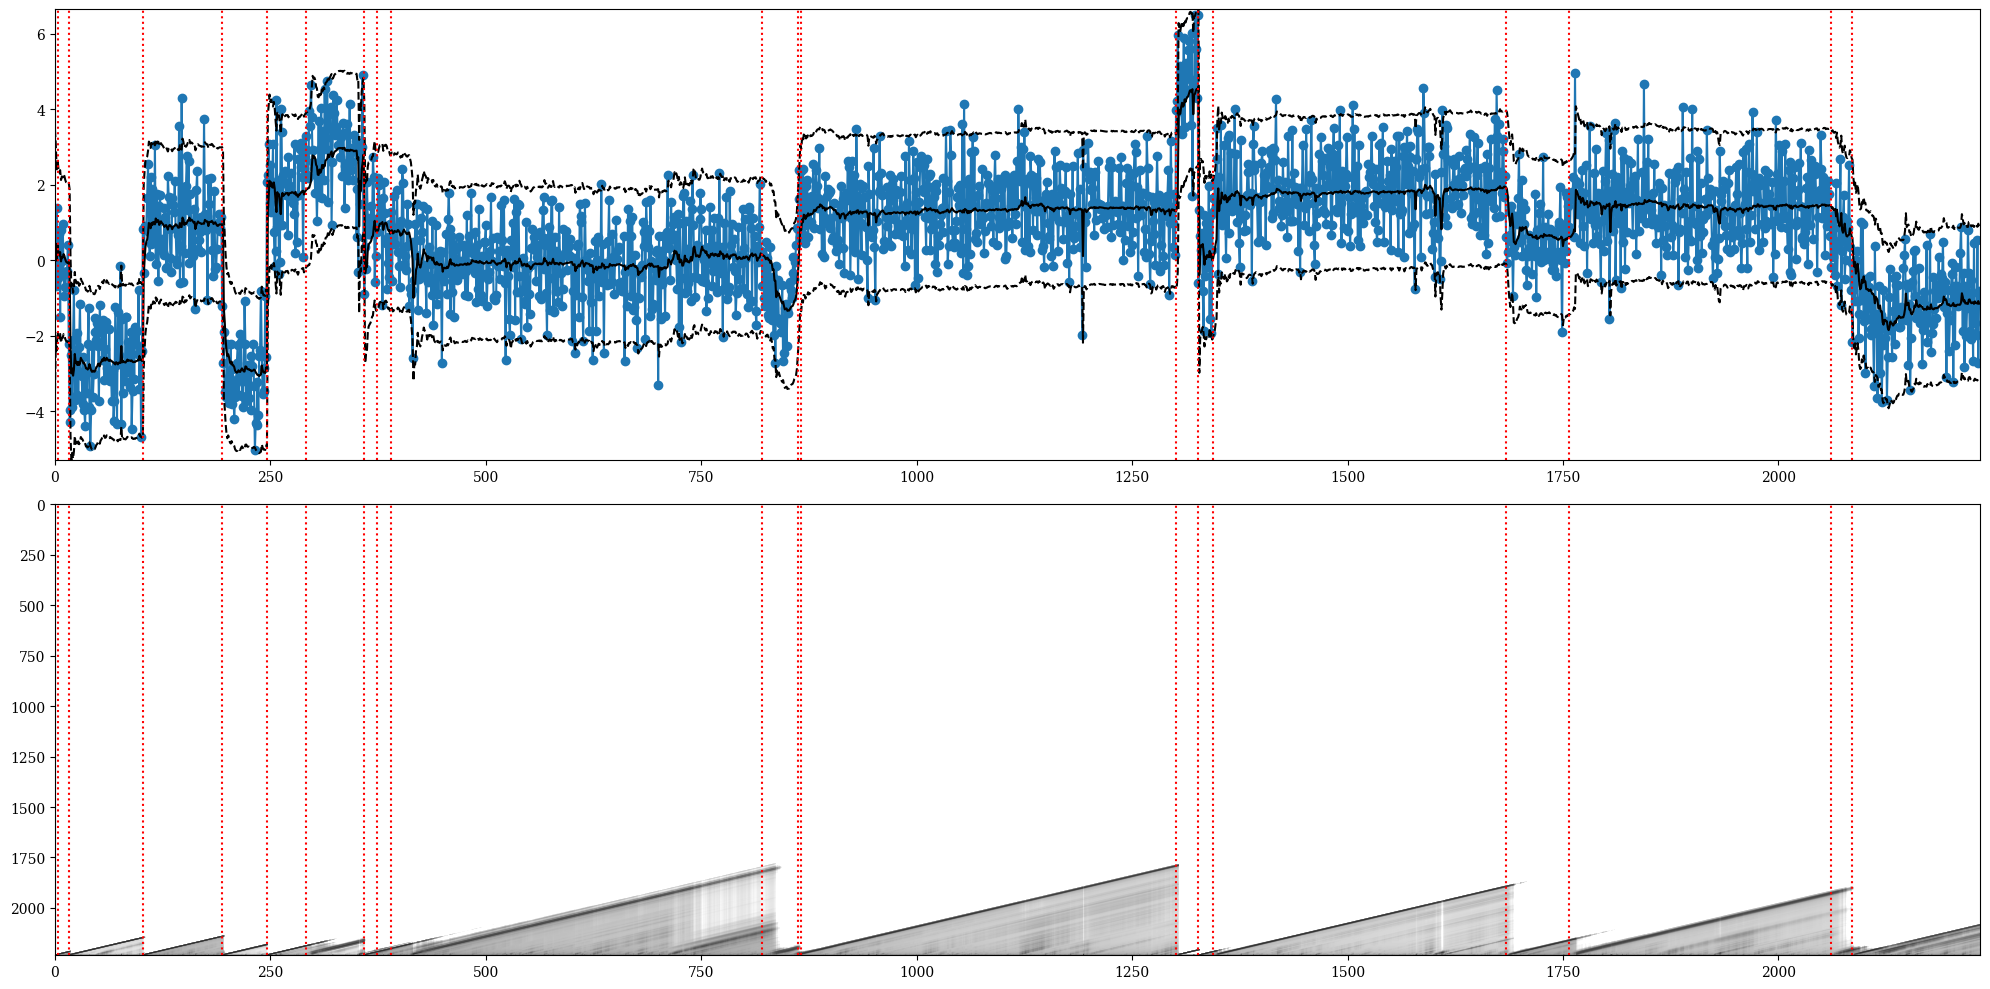

In [26]:
from curvemetrics.bocd import *

T      = cumulative_returns.shape[0]   # Number of observations.
hazard = 1/100  # Constant prior on changepoint probability.
mean0  = 0      # The prior mean on the mean parameter.
var0   = 2      # The prior variance for mean parameter.
varx   = 1      # The known variance of the data.

data, cps      = generate_data(varx, mean0, var0, T, hazard)
model          = GaussianUnknownMean(mean0, var0, varx)
R, pmean, pvar = bocd(data, model, hazard)

plot_posterior(T, data, cps, R, pmean, pvar)

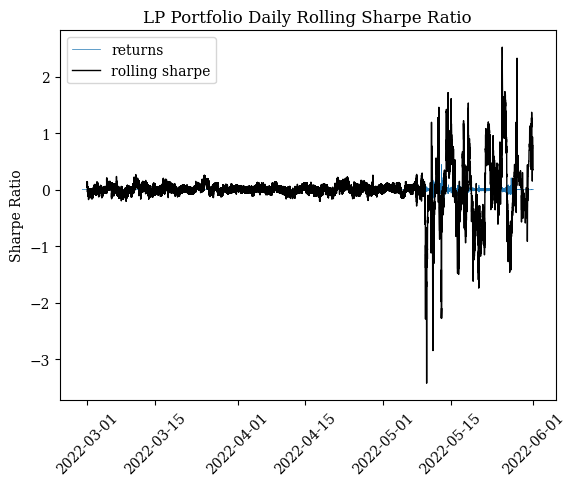

In [27]:
f, ax = plt.subplots()
periods = 60*24
cumulative_returns = final_df['realPrice'].pct_change()
rolling_sharpe = np.sqrt(periods) * cumulative_returns.rolling(periods).mean() / cumulative_returns.rolling(periods).std()
ax.plot(cumulative_returns.index, cumulative_returns, label='returns', linewidth=0.5)
ax.plot(rolling_sharpe.index, rolling_sharpe, label='rolling sharpe', linewidth=1, c='black')
ax.legend()
ax.set_title('LP Portfolio Daily Rolling Sharpe Ratio')
ax.set_ylabel('Sharpe Ratio')
ax.tick_params(axis='x', rotation=45)

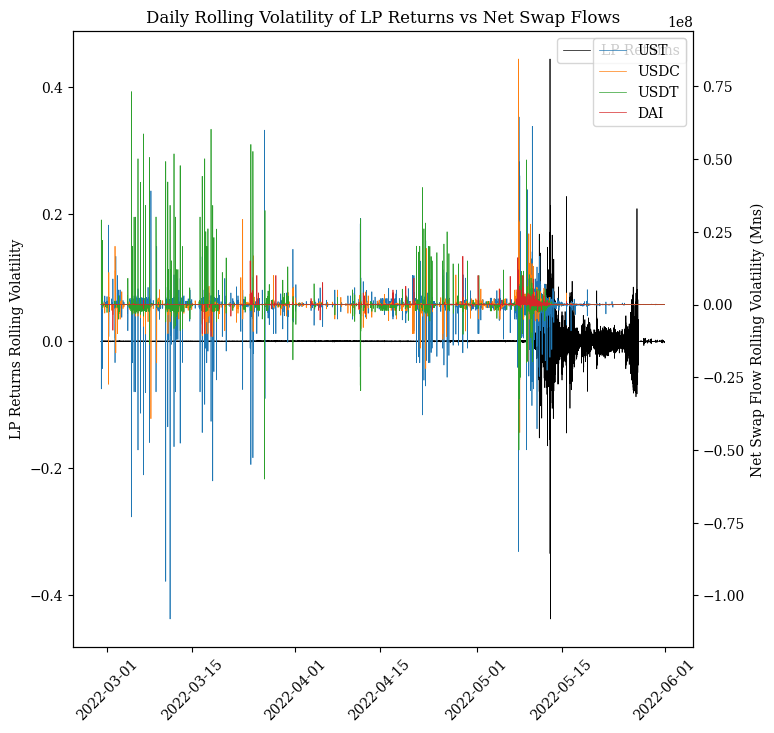

In [26]:
f, ax = plt.subplots(figsize=(8,8))
ax2 = ax.twinx()
periods = 60
returns = final_df['realPrice'].pct_change()
ust_flow = pool_metrics['UST.netSwapFlow']
usdc_flow = pool_metrics['USDC.netSwapFlow']
usdt_flow = pool_metrics['USDT.netSwapFlow']
dai_flow = pool_metrics['DAI.netSwapFlow']

ax2.plot(ust_flow.index, ust_flow, label='UST', linewidth=0.5)
ax2.plot(usdc_flow.index, usdc_flow, label='USDC', linewidth=0.5)
ax2.plot(usdt_flow.index, usdt_flow, label='USDT', linewidth=0.5)
ax2.plot(dai_flow.index, dai_flow, label='DAI', linewidth=0.5)
ax.plot(returns.index, returns, label='LP Returns', c='black', linewidth=0.5)
ax.grid(False)
ax2.grid(False)
ax.set_ylabel('LP Returns Rolling Volatility')
ax2.set_ylabel('Net Swap Flow Rolling Volatility (Mns)')
ax.set_title(f'Daily Rolling Volatility of LP Returns vs Net Swap Flows')
ax.legend()
ax2.legend()
ax.tick_params(axis='x', rotation=45)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


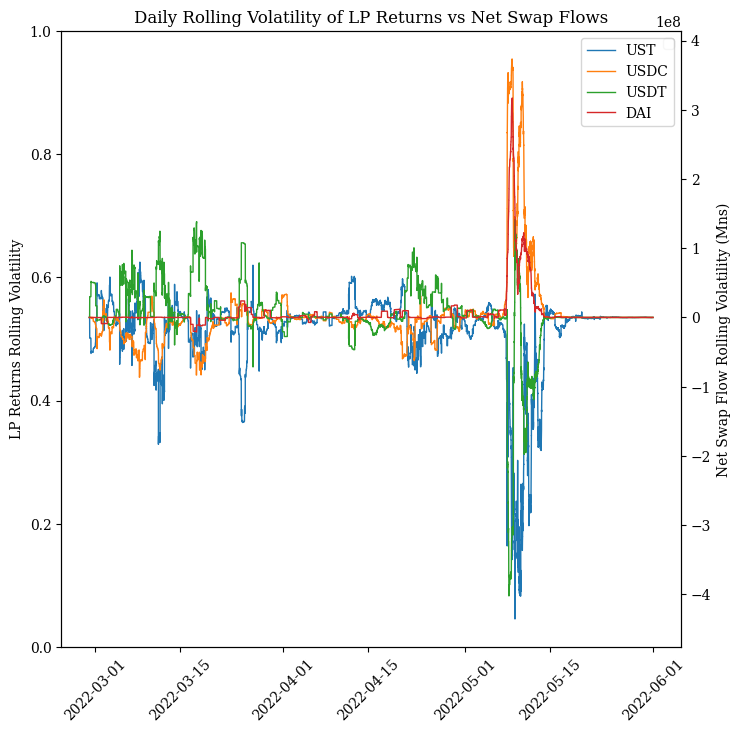

: 

In [29]:
f, ax = plt.subplots(figsize=(8,8))
ax2 = ax.twinx()
periods = 60
returns = final_df['realPrice'].pct_change()
ust_flow = pool_metrics['UST.netSwapFlow'].rolling('1d').sum()
usdc_flow = pool_metrics['USDC.netSwapFlow'].rolling('1d').sum()
usdt_flow = pool_metrics['USDT.netSwapFlow'].rolling('1d').sum()
dai_flow = pool_metrics['DAI.netSwapFlow'].rolling('1d').sum()

ax2.plot(ust_flow.index, ust_flow, label='UST', linewidth=1)
ax2.plot(usdc_flow.index, usdc_flow, label='USDC', linewidth=1)
ax2.plot(usdt_flow.index, usdt_flow, label='USDT', linewidth=1)
ax2.plot(dai_flow.index, dai_flow, label='DAI', linewidth=1)

ax.grid(False)
ax2.grid(False)
ax.set_ylabel('LP Returns Rolling Volatility')
ax2.set_ylabel('Net Swap Flow Rolling Volatility (Mns)')
ax.set_title(f'Daily Rolling Volatility of LP Returns vs Net Swap Flows')
ax.legend()
ax2.legend()
ax.tick_params(axis='x', rotation=45)

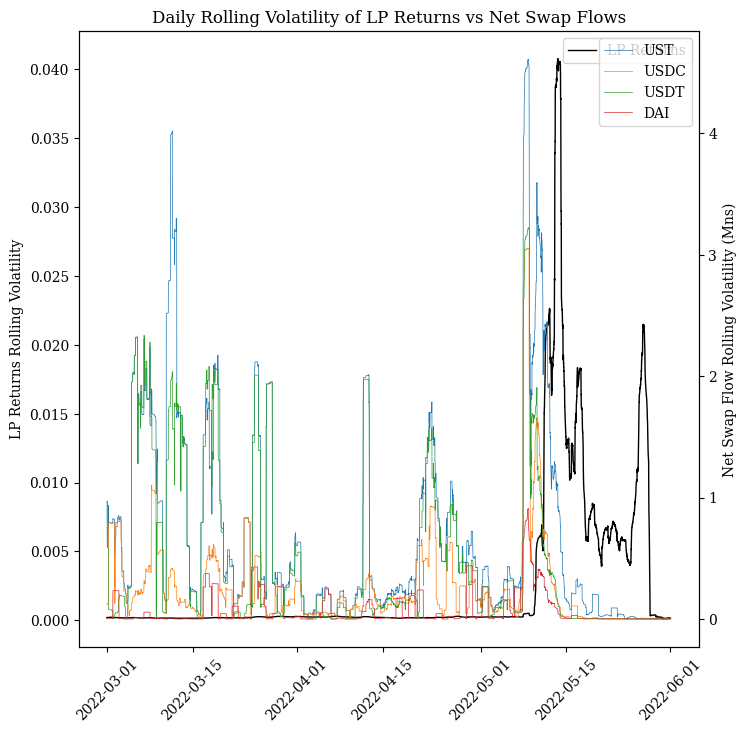

In [29]:
f, ax = plt.subplots(figsize=(8,8))
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice'].pct_change().rolling(periods).std()
ust_rolling_std = pool_metrics['UST.netSwapFlow'].rolling(periods).std()/1e6
usdc_rolling_std = pool_metrics['USDC.netSwapFlow'].rolling(periods).std()/1e6
usdt_rolling_std = pool_metrics['USDT.netSwapFlow'].rolling(periods).std()/1e6
dai_rolling_std = pool_metrics['DAI.netSwapFlow'].rolling(periods).std()/1e6

ax.plot(return_variance.index, return_variance, label='LP Returns', c='black', linewidth=1)
ax2.plot(ust_rolling_std.index, ust_rolling_std, label='UST', linewidth=0.5)
ax2.plot(usdc_rolling_std.index, usdc_rolling_std, label='USDC', linewidth=0.5)
ax2.plot(usdt_rolling_std.index, usdt_rolling_std, label='USDT', linewidth=0.5)
ax2.plot(dai_rolling_std.index, dai_rolling_std, label='DAI', linewidth=0.5)
ax.grid(False)
ax2.grid(False)
ax.set_ylabel('LP Returns Rolling Volatility')
ax2.set_ylabel('Net Swap Flow Rolling Volatility (Mns)')
ax.set_title(f'Daily Rolling Volatility of LP Returns vs Net Swap Flows')
ax.legend()
ax2.legend()
ax.tick_params(axis='x', rotation=45)

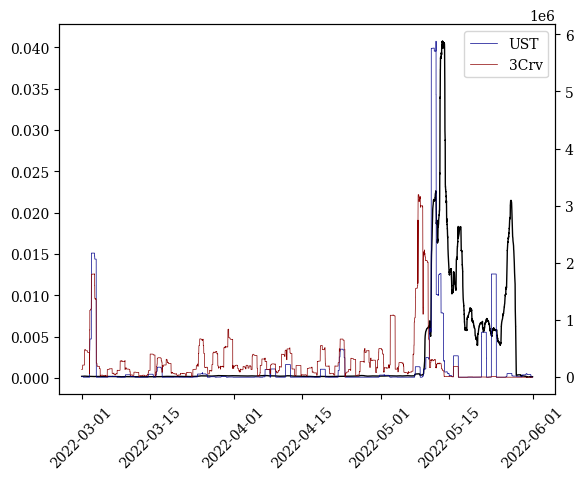

In [30]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice'].pct_change().rolling(periods).std()
ust_rolling_std = pool_metrics['UST.netLPFlow'].rolling(periods).std()/1e6
crv_rolling_std = pool_metrics['3Crv.netLPFlow'].rolling(periods).std()/1e18
ax.plot(return_variance.index, return_variance, label='returns', linewidth=1, c='black')
ax2.plot(ust_rolling_std.index, ust_rolling_std, label='UST', linewidth=0.5, c='darkblue')
ax2.plot(crv_rolling_std.index, crv_rolling_std, label='3Crv', linewidth=0.5, c='darkred')
ax.grid(False)
ax2.grid(False)
ax2.legend()
ax.tick_params(axis='x', rotation=45)

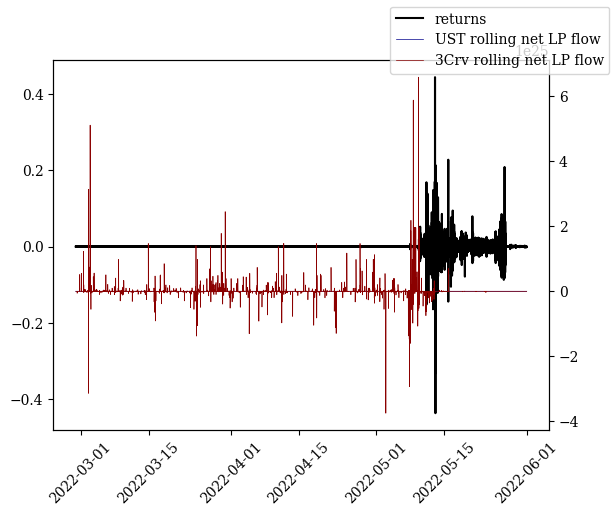

In [31]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice'].pct_change()
ust_rolling_std = pool_metrics['UST.netLPFlow']
crv_rolling_std = pool_metrics['3Crv.netLPFlow']
ax.plot(return_variance.index, return_variance, label='returns', c='black')
ax2.plot(ust_rolling_std.index, ust_rolling_std, label='UST rolling net LP flow', linewidth=0.5, c='darkblue')
ax2.plot(crv_rolling_std.index, crv_rolling_std, label='3Crv rolling net LP flow', linewidth=0.5, c='darkred')
f.legend()
ax.tick_params(axis='x', rotation=45)

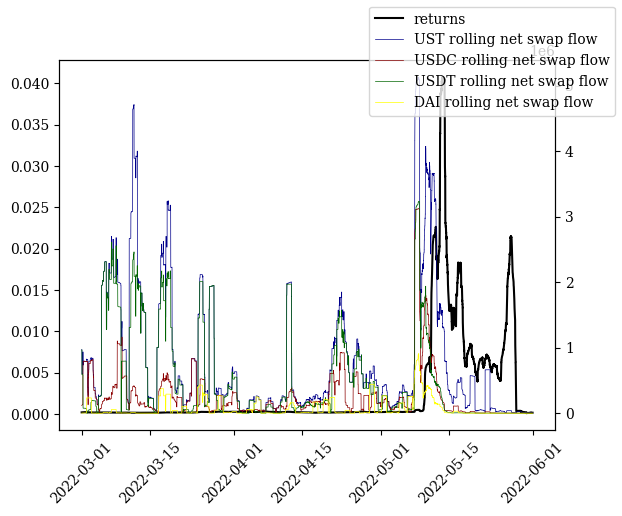

In [32]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice'].pct_change().rolling(periods).std()
ust_rolling_std = pool_metrics['UST.absSwapFlow'].rolling(periods).std()
usdc_rolling_std = pool_metrics['USDC.absSwapFlow'].rolling(periods).std()
usdt_rolling_std = pool_metrics['USDT.absSwapFlow'].rolling(periods).std()
dai_rolling_std = pool_metrics['DAI.absSwapFlow'].rolling(periods).std()
ax.plot(return_variance.index, return_variance, label='returns', c='black')
ax2.plot(ust_rolling_std.index, ust_rolling_std, label='UST rolling net swap flow', linewidth=0.5, c='darkblue')
ax2.plot(usdc_rolling_std.index, usdc_rolling_std, label='USDC rolling net swap flow', linewidth=0.5, c='darkred')
ax2.plot(usdt_rolling_std.index, usdt_rolling_std, label='USDT rolling net swap flow', linewidth=0.5, c='darkgreen')
ax2.plot(dai_rolling_std.index, dai_rolling_std, label='DAI rolling net swap flow', linewidth=0.5, c='yellow')
f.legend()
ax.tick_params(axis='x', rotation=45)

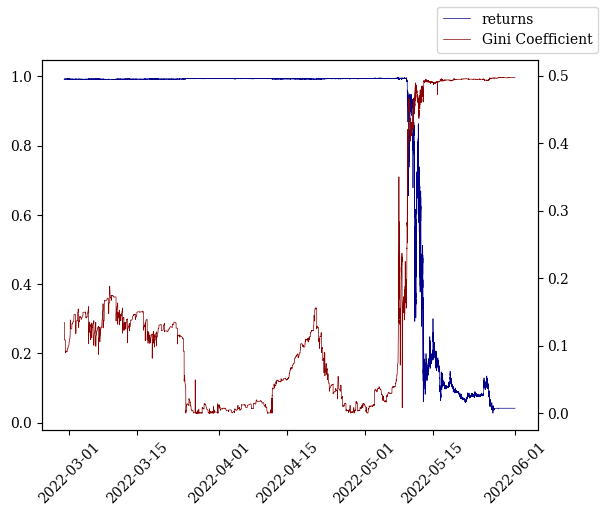

In [33]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
returns = final_df['realPrice']
gini_coefficient = pool_metrics['giniCoefficient']
ax.plot(returns.index, returns, label='returns', linewidth=0.5, c='darkblue')
ax2.plot(gini_coefficient.index, gini_coefficient, label='Gini Coefficient', linewidth=0.5, c='darkred')
ax.grid(False)
ax2.grid(False)
f.legend()
ax.tick_params(axis='x', rotation=45)

In [34]:
pool_metrics['shannonsEntropy'] = MetricsProcessor.shannons_entropy(pool_data, pool)

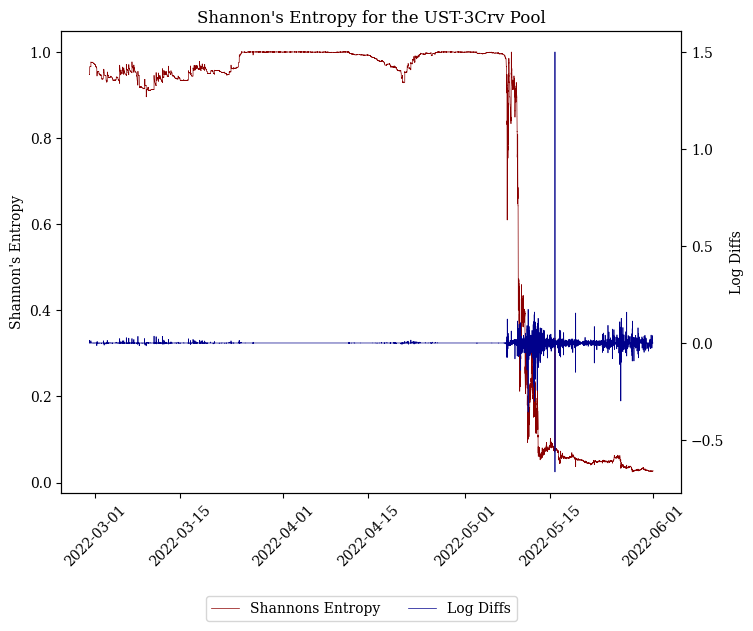

: 

In [66]:
f, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()
shannon = pool_metrics['shannonsEntropy']
metric = np.log1p(shannon.pct_change())
ax.plot(shannon.index, shannon, label='Shannons Entropy', linewidth=0.5, c='darkred')
ax2.plot(metric.index, metric, label='Log Diffs', linewidth=0.5, c='darkblue')
ax.set_title('Shannon\'s Entropy for the UST-3Crv Pool')
ax.grid(False)
ax2.grid(False)
ax.set_ylabel("Shannon's Entropy")
ax2.set_ylabel("Log Diffs")
ax.tick_params(axis='x', rotation=45)
f.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
f.savefig('./figs/shannon_ust_3crv.png', bbox_inches='tight')

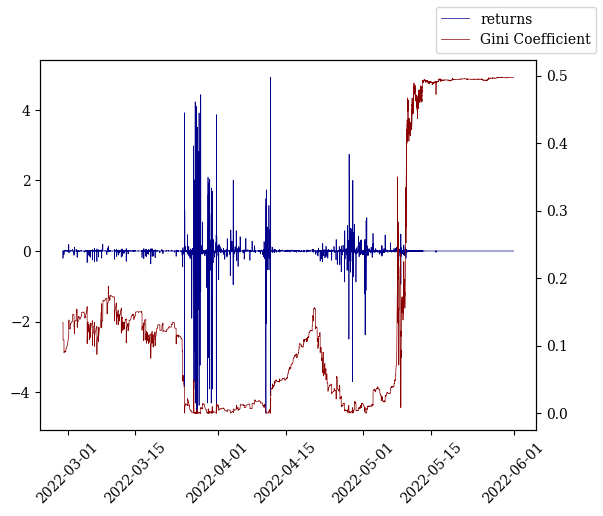

In [41]:
f, ax = plt.subplots()
ax2 = ax.twinx()
gini_coefficient = pool_metrics['giniCoefficient']
metric = np.log1p(gini_coefficient.pct_change())
ax.plot(metric.index, metric, label='returns', linewidth=0.5, c='darkblue')
ax2.plot(gini_coefficient.index, gini_coefficient, label='Gini Coefficient', linewidth=0.5, c='darkred')
ax.grid(False)
ax2.grid(False)
f.legend()
ax.tick_params(axis='x', rotation=45)

In [1]:
f, ax = plt.subplots(figsize=(8,8))
periods = 60*24
returns = final_df['realPrice']
hodl = 0.5 * final_df['UST'] + 0.5 * final_df['3Crv']
ax.plot(returns.index, returns, label='LP Share Price', linewidth=0.5, c='darkblue')
ax.plot(hodl.index, hodl, label='HODL', linewidth=0.5, c='darkred')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Price (USD)")
ax.set_title("Share Price of LP\'ing vs HODLing UST & 3Crv")
ax.grid(True)
f.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
f.savefig(f'./figs/lp_vs_hodl.png', bbox_inches="tight")

NameError: name 'plt' is not defined

In [36]:
tokens = set(swaps_data['tokenBought']).union(set(swaps_data['tokenSold']))
ohlcvs = {}
ignore = set(['0x6c3f90f043a72fa612cbac8115ee7e52bde6e490']) # metapool, ignore LP token for now
tokens -= ignore
for token in tokens:
    ohlcvs[token] = datahandler.get_ohlcv_data(token, start_ts, end_ts)

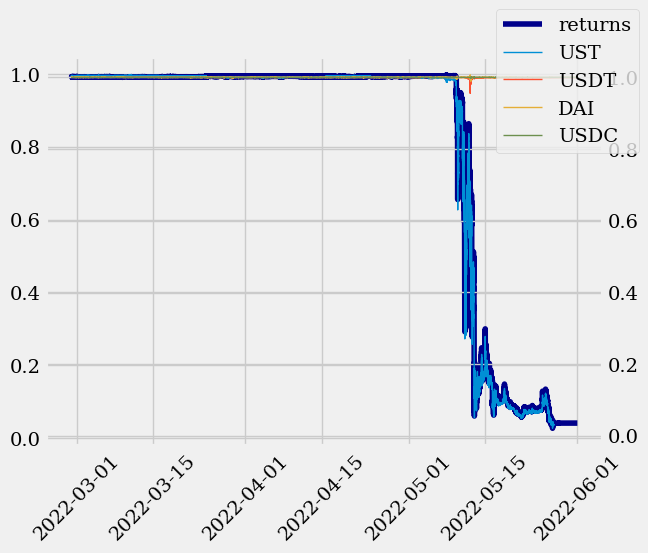

In [37]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice']
for token in tokens:
    ax2.plot(ohlcvs[token].index, ohlcvs[token]['close'], label=token_metadata[token]['symbol'], linewidth=1)
ax.plot(return_variance.index, return_variance, label='returns', c='darkblue')
f.legend()
ax.tick_params(axis='x', rotation=45)

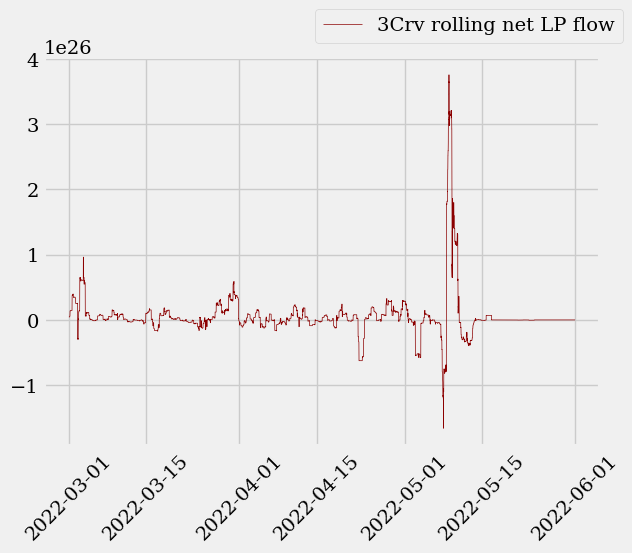

In [38]:
f, ax = plt.subplots()
foo = pool_metrics['3Crv.netLPFlow'].rolling(periods).sum()
ax.plot(foo.index, foo, label='3Crv rolling net LP flow', linewidth=0.5, c='darkred')
f.legend()
ax.tick_params(axis='x', rotation=45)

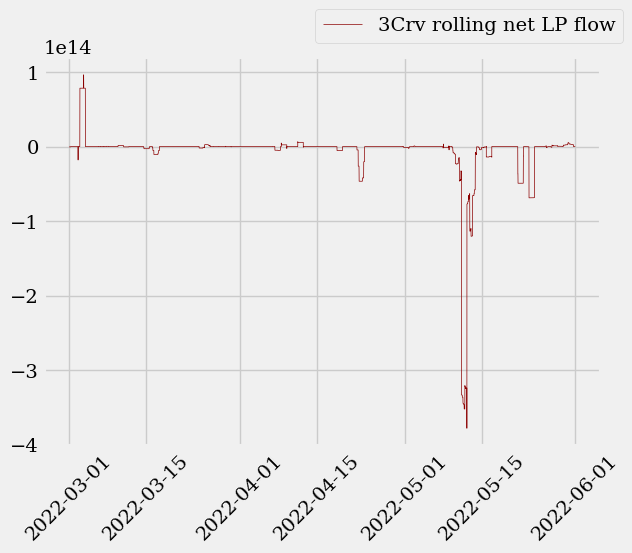

In [39]:
f, ax = plt.subplots()
foo = pool_metrics['UST.netLPFlow'].rolling(periods).sum()
ax.plot(foo.index, foo, label='3Crv rolling net LP flow', linewidth=0.5, c='darkred')
f.legend()
ax.tick_params(axis='x', rotation=45)